In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import scipy 
import xmltodict
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

In [4]:
def add_root_path(G_root, root_dict, root_id, split = 'left', root_deg = 0):
    
    """
    helper func called by 'rsml2nx', add primary or lateral root to the graph
    - node get the same name as its position.
    - node attr: {t       :  appiration time, 
                 root_id :  root_id,
                 split   :  'left' or 'right'
                 root_deg:  0 if pirmary else 1}
    - edge attr:{ length  :  length,
                  t       :  the appiration time of the later node,
                  split   :  'left' or 'right'}
    - added the root length to graph attribute, the list of root length.
    """
    # add node:
    if type(root_dict) == list:
        for i, node in enumerate(root_dict):
            G_root.add_node((float(node['@coord_x']), float(node['@coord_y'])),
                            t = round(float(node['@coord_th'])),
                            root_id = root_id,
                            split = split,
                            root_deg = root_deg)
        

        # add edge:
        total_length = 0
        for i in range(len(root_dict)-1):
            u = (float(root_dict[i]['@coord_x']), float(root_dict[i]['@coord_y']))
            v =  (float(root_dict[i+1]['@coord_x']), float(root_dict[i+1]['@coord_y']))
            seg_length = scipy.spatial.distance.euclidean(u, v)
            G_root.add_edge(u, v, length = seg_length, t = max( G_root.nodes[u]['t'], G_root.nodes[v]['t']), split = split)
            total_length += seg_length

        G_root.graph[f'lengths_{split}'].append(total_length)
        
    return

In [5]:
def rsml2nx(file):
    """
    RSML to nx directed graph. Left and right root nodes are labeled with "split" attribute. 
    
    --------
    INPUT:
        file  : string, RSML file path/name in the local directory
        
    --------
    OUTPUT: 
        G_root    : nx graph object for the RSML+t Hirros pipeline output
        RSA_dict  : python dict, the dictionary version of the RSML file.
    """

    # convert xml to dict:
    with open(file, 'r', encoding='utf-8') as file:
        rsml = file.read()

    RSA_dict = xmltodict.parse(rsml)
    
    G_root = nx.DiGraph()
    
    G_root.graph['lengths_left'] = []
    G_root.graph['lengths_right'] = []
    
    
    if  RSA_dict['rsml']['scene']['plant'][0]['root']['geometry']['polyline']['point'][0]['@coord_x'] < RSA_dict['rsml']['scene']['plant'][1]['root']['geometry']['polyline']['point'][0]['@coord_x']:       
        # read left:
        left = RSA_dict['rsml']['scene']['plant'][0]
        # read right:
        right = RSA_dict['rsml']['scene']['plant'][1]
    else:
         # read right:
        right = RSA_dict['rsml']['scene']['plant'][0]
        # read left:
        left = RSA_dict['rsml']['scene']['plant'][1]

    # primary root:
    primary = left['root']['geometry']['polyline']['point']
    add_root_path(G_root, primary, root_id = left['root']['@ID'], split = 'left', root_deg = 0)

    # lateral roots:
    for lr in left['root']['root']:
        # for each lateral:
        lateral = lr['geometry']['polyline']['point']
        add_root_path(G_root, lateral, root_id = lr['@ID'], split = 'left', root_deg = 1)

    # primary root:
    primary = right['root']['geometry']['polyline']['point']
    add_root_path(G_root, primary, root_id = right['root']['@ID'], split = 'right', root_deg = 0)
    
    # lateral roots:
    for lr in right['root']['root']:
        # for each lateral:
        lateral = lr['geometry']['polyline']['point']
        add_root_path(G_root, lateral, root_id = lr['@ID'], split = 'right', root_deg = 1)
    
    
    # remove self loops:
    G_root.remove_edges_from(nx.selfloop_edges(G_root))
    pos = np.array(list(G_root.nodes()))

    
    # save plotting ratio:
    mins = np.min(pos, 0)
    maxes = np.max(pos, 0)

    G_root.graph['x_min'] = mins[0]
    G_root.graph['y_min'] = mins[1]

    G_root.graph['x_max'] = maxes[0]
    G_root.graph['y_max'] = maxes[1]

    G_root.graph['ratio'] = (maxes[0] - mins[0]) / (maxes[1] - mins[1])
    
    return G_root, RSA_dict


In [6]:
def plot_rsmlt(G, plate):
    
    'plot root graph with node color coded by appriation time'
    
    pos = np.array(list(G_root.nodes()))

    node_positions = {}
    node_color = []

    for node in G_root.nodes:
        node_positions[node] = ( node[0], - node[1])
        node_color.append(G_root.nodes[node]['t'])

    fig, ax = plt.subplots(figsize = (14,10/G_root.graph['ratio']))

    nx.draw(G_root, pos=node_positions, node_size = 0, width = .7, arrowsize = 5, ax = ax)
    split_root_node = nx.draw_networkx_nodes(G_root, pos=node_positions, node_size= 10, node_color = node_color, ax = ax,  cmap=plt.cm.magma) 
    ax.set_title(f'RSML + t, plate {plate} example', fontsize = 20)
    plt.colorbar(split_root_node, aspect= 50, shrink = .5, label = 'appiration time (h)', orientation = 'vertical')
    plt.tight_layout()
    
    plt.show()  
    
#     fig.savefig(f'SR_rsml_pilot/output/{plate}_RSMLt.pdf')

In [7]:
def get_growth(G_root):
    
    """
    Get 
    --------
    imput:
        G_root  : nx graph object, split root graph
    --------
    output: 
        left_growth    : list of additional length of the left side at each time interval 
        left_tot       : list of cumulative length of the left side 
        right_growth   : list of additional length of the right side at each time interval 
        right_tot      : list of cumulative length of the right side
        
    """

    # create empty list of list for lengths of root segments at different time
    left_lengths = [ [] for _ in range(187//6) ]

    # add the segments
    for edge in G_root.edges:
        if G_root.edges[edge]['split'] == 'left':
            length = G_root.edges[edge]['length']
            left_lengths[G_root.edges[edge]['t']//6-1].append(length)
    
    # get total additional length at each time interval
    left_growth = []
    for i in range(len(left_lengths)):
        tot = np.array(left_lengths[i]).sum()
        left_growth.append(tot)
    
    # get the running total
    left_tot = []
    running = 0
    for i in range(len(left_growth)):
        running += left_growth[i]
        left_tot.append(running)


    right_lengths = [ [] for _ in range(187//6) ]

    for edge in G_root.edges:
        if G_root.edges[edge]['split'] == 'right':
            length = G_root.edges[edge]['length']
            right_lengths[G_root.edges[edge]['t']//6-1].append(length)

    right_growth = []
    for i in range(len(right_lengths)):
        tot = np.array(right_lengths[i]).sum()
        right_growth.append(tot)

    right_tot = []
    running = 0
    for i in range(len(right_growth)):
        running += right_growth[i]
        right_tot.append(running)

    return left_lengths, left_tot, right_lengths, right_tot

In [8]:
def plot_growth(left_tot, right_tot, plate):
    
    'plot cumulative growths over time'
    
    fig, ax = plt.subplots(figsize = [8,6])
    plt.plot(np.array(left_tot)*19/1000, label = 'left')
    plt.plot(np.array(right_tot)*19/1000, label = 'right')
    plt.legend(fontsize = 14)
    tps = list(range(0, 187, 6))
    xticks = list(range(0, 32, 1))
    ax.set_xticks(xticks[::6])
    ax.set_xticklabels(tps[::6])
    ax.set_xlabel('hours', fontsize = 14)
    ax.set_ylabel('total length (mm)', fontsize = 14)
    ax.set_title(f'{plate} growth curve', fontsize = 16)
    ax.set_ylim([0, 200])
    plt.show()
    
#     fig.savefig(f'SR_rsml_pilot/output/{plate}_growth_curve.pdf')

-----------

### Use plate example:

In [16]:
split_file = 'p55.rsml'

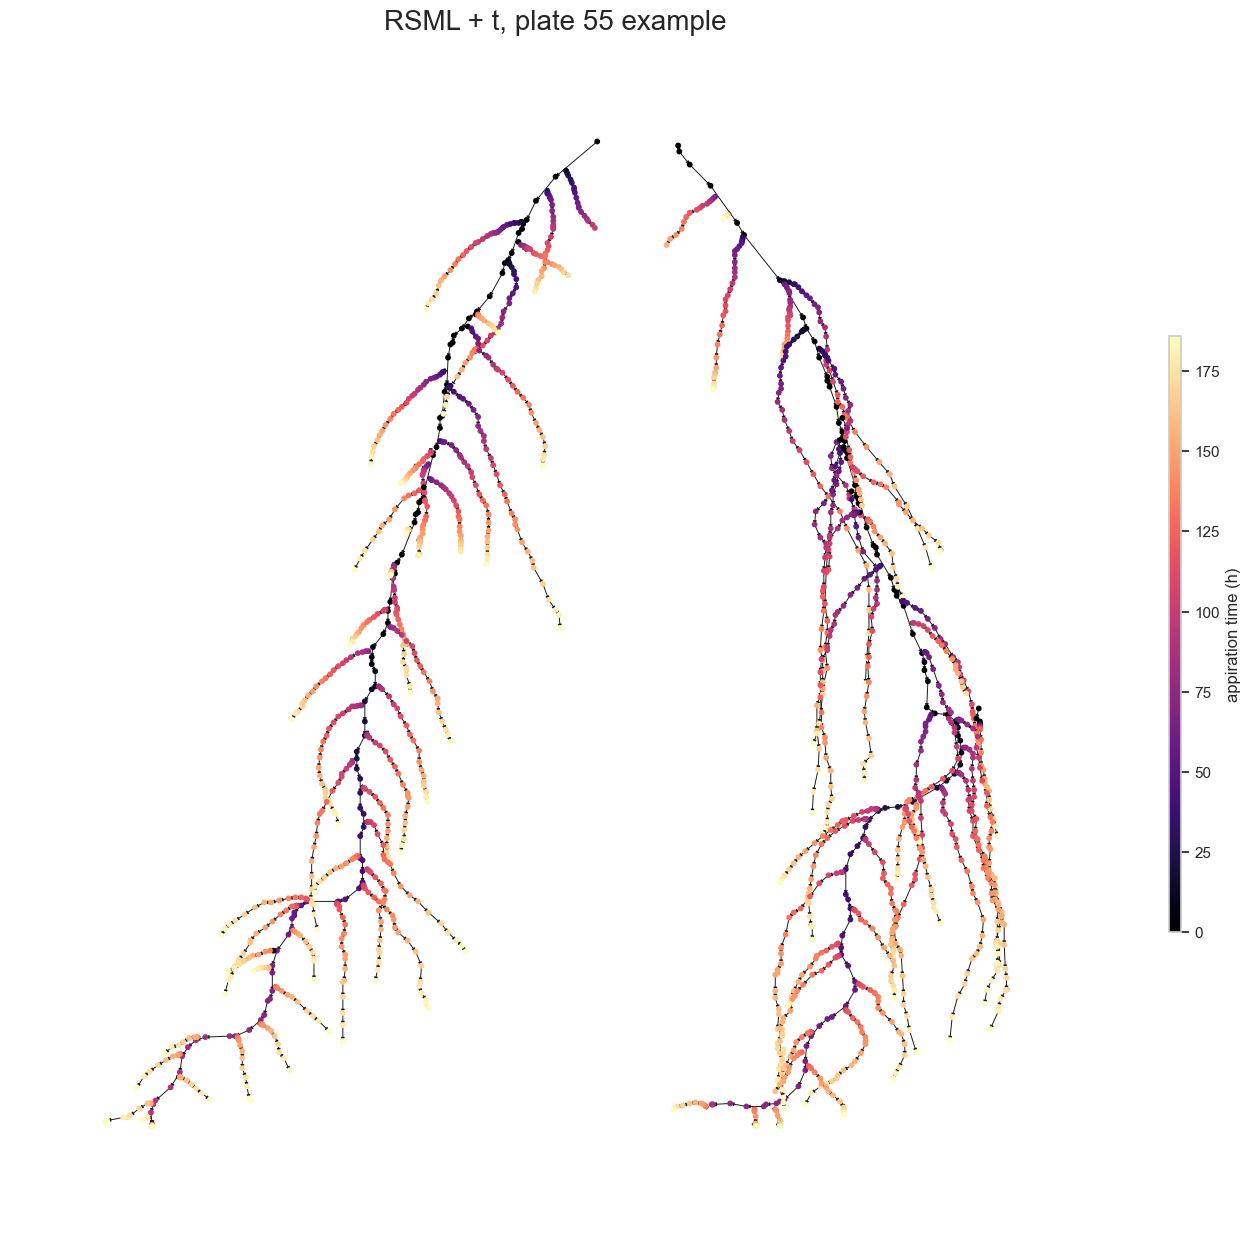

In [17]:
G_root, _ = rsml2nx(split_file)
plot_rsmlt(G_root, plate = '55')

In [18]:
print('left number LR:', len(G_root.graph['lengths_left']) - 1)
print('right number of LR:', len(G_root.graph['lengths_right']) - 1)
print('left total length(pixel):', round(np.array(G_root.graph['lengths_left']).sum()))
print('right total length(pixel):', round(np.array(G_root.graph['lengths_right']).sum()))

left number LR: 44
right number of LR: 40
left total length(pixel): 5049
right total length(pixel): 7627


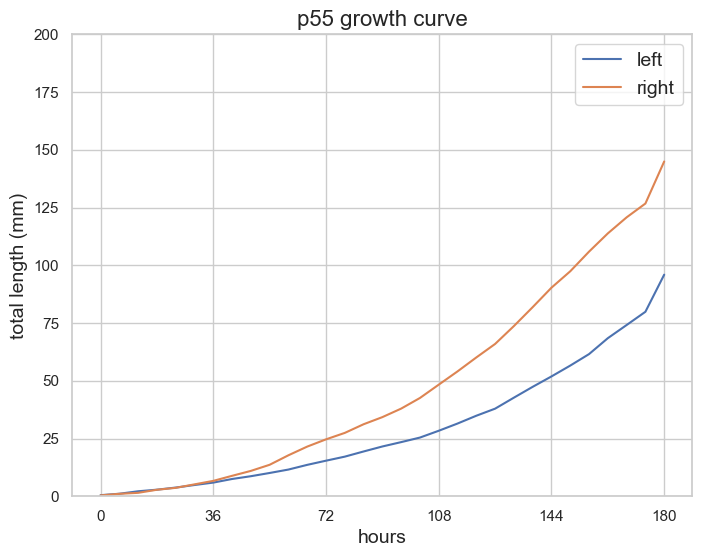

In [19]:
left_lengths, left_tot, right_lengths, right_tot = get_growth(G_root)
plot_growth(left_tot, right_tot, plate = 'p55')